In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import geopandas as gpd
import properscoring as ps
import numpy as np
from sklearn.metrics import r2_score, root_mean_squared_error
from sklearn.feature_selection import mutual_info_regression
import matplotlib as mpl

static_features = ["awc", "bulk_density", "drainage_class_4", "drainage_class_5", "drainage_class_6"]
temporal_prefixes = ["tavg", "prec", "tmin", "tmax", "ndvi", "fpar", "rad", "et0", "cwb", "ssm", "rsm"]
statefp_to_name = {'08':'Colorado', '20':'Kansas', '31':'Nebraska', '40':'Oklahoma', '46':'South Dakota', '48':'Texas'}
scm_to_truncation = {"jan": 9, "feb":11, "mar":13, "apr":15, "may":17, "june":19, "july":21}
truncation_to_date = {
    "3_23": "05 Aug", "3_22": "19 Jul", "3_21": "03 Jul",
    "3_20": "17 Jun", "3_19": "01 Jun", "3_18": "16 May",
    "3_17": "30 Apr", "3_16": "14 Apr", "3_15": "29 Mar",
    "3_14": "13 Mar", "3_13": "25 Feb", "3_12": "09 Feb",
    "3_11": "24 Jan", "3_10": "08 Jan", "3_9": "26 Dec",
    "3_8": "10 Dec", "3_7": "24 Nov", "3_6": "08 Nov",
    "3_5": "23 Oct", "3_4": "07 Oct", "3_3": "21 Sep"
}
time_step_to_date = {
    23: "05 Aug", 22: "19 Jul", 21: "03 Jul",
    20: "17 Jun", 19: "01 Jun", 18: "16 May",
    17: "30 Apr", 16: "14 Apr", 15: "29 Mar",
    14: "13 Mar", 13: "25 Feb", 12: "09 Feb",
    11: "24 Jan", 10: "08 Jan", 9: "26 Dec",
    8: "10 Dec", 7: "24 Nov", 6: "08 Nov",
    5: "23 Oct", 4: "07 Oct", 3: "21 Sep"
}

### 1. End-Of-Season Analysis

#### 1.1 Actual vs. Predicted Yield

In [2]:
# SETUP
type = "test" # one of val or test
truncation = "3_23" # one of the truncation_to_date keys

pred_true = pd.read_csv("data/results_US/truncation/{}_y_true_y_pred_timesteps_{}.csv".format(type, truncation)).drop(columns=["Unnamed: 0"])
features = pd.read_csv('C:/Users/Max Zachow/OneDrive - TUM/Dokumente/GitHub/seasonal-yield-forecast/data/preprocessed/US/cy_bench_16daybins_wheat_US_v8.csv')
yield_df = pd.read_csv('C:/Users/Max Zachow/OneDrive - TUM/Dokumente/GitHub/seasonal-yield-forecast/data/CY-Bench/US/wheat/yield_wheat_US.csv')	
us_shape = gpd.read_file("data/shapefiles/US/tl_2023_us_county.shp")

# YIELD DF
yield_df = yield_df.rename(columns={"harvest_year":"year"})

# US GEODATA
us_shape = us_shape.assign(adm_id="US-"+us_shape["STATEFP"] + "-" + us_shape["COUNTYFP"])[["adm_id", "geometry", "STATEFP"]]
us_counties = us_shape.loc[us_shape["STATEFP"].isin(['08', '20', '31', '40', '46', '48'])].reset_index(drop=True)
us_counties["STATEFP"] = us_counties["STATEFP"].apply(lambda x: statefp_to_name[x])
us_states = us_counties[["STATEFP", "geometry"]].dissolve(by="STATEFP").reset_index()

# RESULTS
xy = (features.loc[(features["adm_id"].isin(pred_true["adm_id"].unique())) & (features["harvest_year"].isin(pred_true["year"].unique())), 
        ["adm_id", "harvest_year", "yield_-5", "yield_-4", "yield_-3", "yield_-2", "yield_-1"]]
        .rename(columns={"harvest_year":"year"})
        .merge(pred_true, on=["adm_id", "year"], how="right")
        .rename(columns={"y_true": "yield"})
        .assign(threeyearavg = lambda x: x[["yield_-3", "yield_-2", "yield_-1"]].mean(axis=1),
                fiveyearavg = lambda x: x[["yield_-5", "yield_-4", "yield_-3", "yield_-2", "yield_-1"]].mean(axis=1))
        .drop(columns=["yield_-1", "yield_-2", "yield_-3", "yield_-4", "yield_-5"])
        .merge(us_counties[["STATEFP", "adm_id"]], on="adm_id", how="left")
        .merge(yield_df[["adm_id", "year", "harvest_area"]], how="left", on=["adm_id", "year"])
)

xy = (yield_df.loc[(yield_df["adm_id"].isin(pred_true["adm_id"].unique())) & (yield_df["year"] < 2021),
             ["adm_id", "year", "harvest_area"]].sort_values(by=["adm_id", "year"], ascending=False).groupby("adm_id").head(5).groupby("adm_id")["harvest_area"].mean()
 .reset_index().rename(columns={"harvest_area":"harvest_area_5yravg"}).merge(xy, on="adm_id", how="right")
 .assign(county_mean=(xy["yield"]+3*xy["threeyearavg"]) / 4))

state_year_level = xy.groupby(['STATEFP', 'year']).apply(
    lambda x: pd.Series({
        'weighted_y_pred': np.average(x['y_pred'], weights=x['harvest_area_5yravg']),
        'weighted_threeyearavg': np.average(x['threeyearavg'], weights=x['harvest_area']),
        'weighted_fiveyearavg': np.average(x['fiveyearavg'], weights=x['harvest_area']),
        'weighted_yield': np.average(x['yield'], weights=x['harvest_area'])
    })
).reset_index()

In [3]:
yield_df = yield_df.rename(columns={"year":"harvest_year"})
df = yield_df.merge(features[["harvest_year", "adm_id"]], on=["harvest_year", "adm_id"], how="inner")[[ "adm_id", "harvest_year", "yield"]]

In [4]:
df.loc[df["harvest_year"].between(2021,2023)].shape

(774, 3)

In [5]:
# Define the ranges
bins = [2004, 2017, 2020, 2023]
labels = ['2004-2017', '2018-2020', '2021-2023']

# Create a new column 'year_range' based on the bins
df['year_range'] = pd.cut(df['harvest_year'], bins=bins, labels=labels, right=True)

# Group by 'year_range' and count the number of rows in each range
year_range_counts = df['year_range'].value_counts().sort_index()
print(year_range_counts)

year_range
2004-2017    4754
2018-2020     793
2021-2023     774
Name: count, dtype: int64


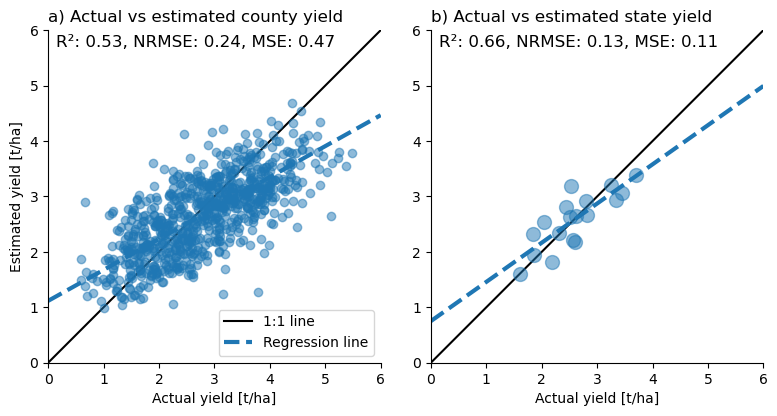

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

# Plot for county-level data on ax[0]
ax[0].plot([0, 6], [0, 6], "black", label="1:1 line")
ax[0].set_aspect('equal', adjustable='box')
ax[0].plot(xy["yield"], xy["y_pred"], "o", alpha=0.5)
slope, bias = np.polyfit(xy["yield"], xy["y_pred"], 1)
ax[0].plot([0, 6], [bias, slope * 6 + bias], color='C0', linewidth=3, linestyle="--", label="Regression line")
ax[0].legend(loc="lower right")
ax[0].set_xlim(0, 6)
ax[0].set_ylim(0, 6)

ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].set_title("a) Actual vs estimated county yield", loc="left")
ax[0].set_xlabel("Actual yield [t/ha]")
ax[0].set_ylabel("Estimated yield [t/ha]")

# Compute the metrics for county-level data
r2 = round(r2_score(xy["yield"], xy["y_pred"]), 2)
nrmse = round(root_mean_squared_error(xy["yield"], xy["y_pred"]) / xy["yield"].mean(), 2)
mse = round(np.mean((xy["yield"] - xy["y_pred"])**2), 2)

# Add text with metrics to the plot
ax[0].text(0.15, 5.7, f"R²: {r2}, NRMSE: {nrmse}, MSE: {mse}", fontsize=12)

# Plot for state-level data on ax[1]
ax[1].plot([0, 6], [0, 6], "black")
ax[1].set_aspect('equal', adjustable='box')
ax[1].plot(state_year_level["weighted_yield"], state_year_level["weighted_y_pred"], "o", alpha=0.5, markersize=10)
slope, bias = np.polyfit(state_year_level["weighted_yield"], state_year_level["weighted_y_pred"], 1)
ax[1].plot([0, 6], [bias, slope * 6 + bias], color='C0', linewidth=3, linestyle="--")

ax[1].set_xlim(0, 6)
ax[1].set_ylim(0, 6)

ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].set_title("b) Actual vs estimated state yield", loc="left")
ax[1].set_xlabel("Actual yield [t/ha]")
#ax[1].set_ylabel("Estimated yield [t/ha]")

# Compute the metrics for state-level data
r2_state = round(r2_score(state_year_level["weighted_yield"], state_year_level["weighted_y_pred"]), 2)
nrmse_state = round(root_mean_squared_error(state_year_level["weighted_yield"], state_year_level["weighted_y_pred"]) / state_year_level["weighted_yield"].mean(), 2)
mse_state = round(np.mean((state_year_level["weighted_yield"] - state_year_level["weighted_y_pred"])**2), 2)

# Add text with metrics to the plot
ax[1].text(0.15, 5.7, f"R²: {r2_state}, NRMSE: {nrmse_state}, MSE: {mse_state}", fontsize=12)

plt.tight_layout()
plt.show()

#### 1.2 Spatial Distribution of RMSE

In [7]:
state_year_level = state_year_level.assign(state_mean=(state_year_level["weighted_yield"]+3*state_year_level["weighted_threeyearavg"]) / 4)

state_rmse = state_year_level.groupby('STATEFP').apply(lambda x: np.sqrt(np.mean((x['weighted_yield'] - x['weighted_y_pred'])**2))).reset_index(name='RMSE')
state_rmse = state_rmse.merge(state_year_level[['STATEFP', 'state_mean']].groupby("STATEFP")["state_mean"].mean().reset_index(), on='STATEFP')
state_rmse['NRMSE'] = 100 * state_rmse['RMSE'] / state_rmse['state_mean']
state_rmse_gdf = us_states.merge(state_rmse, on='STATEFP')

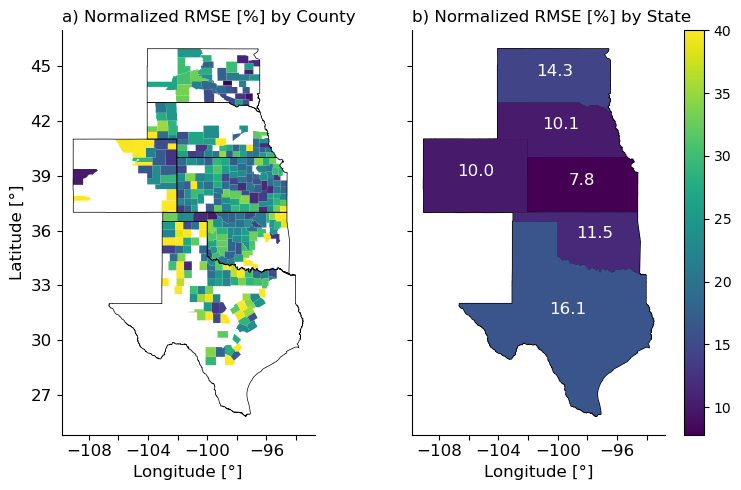

In [8]:
# Calculate rRMSE for each county
rmse_df = xy.groupby('adm_id').apply(lambda x: np.sqrt(np.mean((x['yield'] - x['y_pred'])**2))).reset_index(name='RMSE')
mean_county_mean_df = xy.groupby('adm_id')['county_mean'].mean().reset_index(name='mean_county_mean')
rmse_df = rmse_df.merge(mean_county_mean_df, on='adm_id')
rmse_df['NRMSE'] = 100 * rmse_df['RMSE'] / rmse_df['mean_county_mean']
rmse_gdf = us_counties.merge(rmse_df, on='adm_id')

fs = 12
# Plot the rRMSE values
fig, ax = plt.subplots(1, 2, figsize=(8, 5), sharey=True)

# Plot for county-level data on ax[0]
rmse_gdf.plot(column='NRMSE', cmap='viridis', vmax=40, legend=False, ax=ax[0])
us_states.plot(facecolor="none", edgecolor='black', linewidth=0.5, ax=ax[0])

ax[0].set_title('a) Normalized RMSE [%] by County', loc='left', fontsize=fs)
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].set_xlabel('Longitude [°]', fontsize=fs)
ax[0].set_ylabel('Latitude [°]', fontsize=fs)
ax[0].xaxis.set_major_locator(plt.MaxNLocator(integer=True))
for label in ax[0].get_xticklabels()[::2]:
    label.set_visible(False)
ax[0].yaxis.set_major_locator(plt.MaxNLocator(integer=True))
ax[0].tick_params(axis='both', labelsize=fs)

# Plot for state-level data on ax[1]
us_states.plot(color='lightgrey', edgecolor='black', ax=ax[1])
state_rmse_gdf.plot(column='NRMSE', cmap='viridis', vmax=40, legend=True, ax=ax[1])
ax[1].set_title('b) Normalized RMSE [%] by State', loc='left', fontsize=fs)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].set_xlabel('Longitude [°]', fontsize=fs)
ax[1].xaxis.set_major_locator(plt.MaxNLocator(integer=True))
for label in ax[1].get_xticklabels()[::2]:
    label.set_visible(False)
ax[1].yaxis.set_major_locator(plt.MaxNLocator(integer=True))
ax[1].tick_params(axis='both', labelsize=fs)

# Add rRMSE values to the state polygons
for idx, row in state_rmse_gdf.iterrows():
    ax[1].annotate(text=f"{row['NRMSE']:.1f}", xy=(row['geometry'].centroid.x, row['geometry'].centroid.y),
                   ha='center', fontsize=12, color='white')

plt.tight_layout()
plt.show()

#### Alternative Figure 4

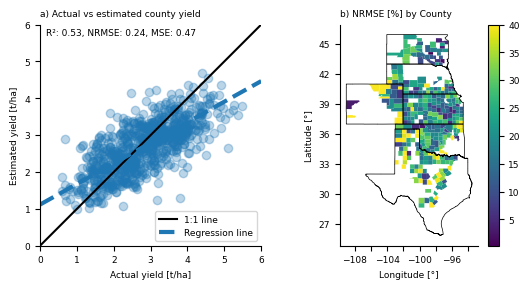

In [9]:
fontsize = 6.5
#dpi = 300
#mpl.rcParams['figure.dpi']= dpi

cm = 1/2.54  # centimeters in inches
# Create subplots
fig, axd = plt.subplot_mosaic([['left', 'right']],
                              figsize=(468.3324*0.0138, (468.3324*0.0138/2.25)),  width_ratios=[0.6, 0.4]) 

# Plot for county-level data on axd["left"]
axd["left"].plot([0, 6], [0, 6], "black", label="1:1 line")
axd["left"].set_aspect('equal', adjustable='box')
axd["left"].scatter(xy["yield"], xy["y_pred"], alpha=0.3)
slope, bias = np.polyfit(xy["yield"], xy["y_pred"], 1)
axd["left"].plot([0, 6], [bias, slope * 6 + bias], color='C0', linewidth=3, linestyle="--", label="Regression line")
axd["left"].legend(loc="lower right", fontsize=fontsize)
axd["left"].set_xlim(0, 6)
axd["left"].set_ylim(0, 6)
axd["left"].tick_params(axis='both', labelsize=fontsize)
axd["left"].spines['top'].set_visible(False)
axd["left"].spines['right'].set_visible(False)
axd["left"].set_title("a) Actual vs estimated county yield", loc="left", fontsize=fontsize)
axd["left"].set_xlabel("Actual yield [t/ha]", fontsize=fontsize)
axd["left"].set_ylabel("Estimated yield [t/ha]", fontsize=fontsize)
axd["left"].set_box_aspect(1)  # Ensure the plot is quadratic


# Compute the metrics for county-level data
r2 = round(r2_score(xy["yield"], xy["y_pred"]), 2)
nrmse = round(root_mean_squared_error(xy["yield"], xy["y_pred"]) / xy["yield"].mean(), 2)
mse = round(np.mean((xy["yield"] - xy["y_pred"])**2), 2)

# Add text with metrics to the plot
axd["left"].text(0.15, 5.7, f"R²: {r2}, NRMSE: {nrmse}, MSE: {mse}", fontsize=fontsize)

# Plot for county-level data on axd["right"]
rmse_gdf.plot(column='NRMSE', cmap='viridis', vmax=40, legend=True, ax=axd["right"])
us_states.plot(facecolor="none", edgecolor='black', linewidth=0.5, ax=axd["right"])
axd["right"].set_title('b) NRMSE [%] by County', loc='left', fontsize=fontsize)
axd["right"].spines['top'].set_visible(False)
axd["right"].spines['right'].set_visible(False)
axd["right"].set_xlabel('Longitude [°]', fontsize=fontsize)
axd["right"].set_ylabel('Latitude [°]', fontsize=fontsize)
axd["right"].xaxis.set_major_locator(plt.MaxNLocator(integer=True))
for label in axd["right"].get_xticklabels()[::2]:
    label.set_visible(False)
axd["right"].yaxis.set_major_locator(plt.MaxNLocator(integer=True))
axd["right"].tick_params(axis='both', labelsize=fontsize)
cbar = axd["right"].get_figure().get_axes()[-1]  # Assuming the colorbar is the last axis added
cbar.tick_params(labelsize=fontsize)

plt.savefig("figure5.png", dpi=300, bbox_inches='tight')

#### 1.3 Table of Annual Performance compared to Baseline Trend Model

In [10]:
# Initialize a list to store the metrics
metrics = []

# Loop through each year in the DataFrame
for year in xy['year'].unique():
    xy_year = xy[xy['year'] == year]
    y_true = xy_year['yield']
    y_pred = xy_year['y_pred']
    y_baseline = xy_year['threeyearavg']
    
    metrics.append({
        'Year': year,
        'RMSE LSTM': np.sqrt(np.mean((y_true - y_pred)**2)) / y_true.mean(),
        'RMSE Trend': np.sqrt(np.mean((y_true - y_baseline)**2)) / y_true.mean(),
        'MSE LSTM': np.mean((y_true - y_pred)**2),
        'MSE Trend': np.mean((y_true - y_baseline)**2),
        'R² LSTM': r2_score(y_true, y_pred),
        'R² Trend': r2_score(y_true, y_baseline)
    })

# Create a DataFrame to store the results
metrics_by_year = pd.DataFrame(metrics).sort_values(by="Year").reset_index(drop=True).round(2)
metrics_by_year

,Year,RMSE LSTM,RMSE Trend,MSE LSTM,MSE Trend,R² LSTM,R² Trend
0,2021,0.22,0.22,0.45,0.42,0.42,0.45
1,2022,0.25,0.34,0.42,0.79,0.62,0.29
2,2023,0.27,0.34,0.55,0.86,0.49,0.19


____

### 2. In-Season Forecast Performance

#### Truncation vs. SCM Approach

In [11]:
df = pd.read_csv("data/results_US/test_y_true_y_pred_timesteps_3_21_may_ba_prec_tavg_tmax_tmin.csv")

In [12]:
(df.assign(truncation=17, limit=21)
          .groupby(["truncation", "limit"]).apply(lambda x: np.mean((x["y_true"] - x["y_pred"])**2)).reset_index(name='MSE'))

,truncation,limit,MSE
0,17,21,1.550972


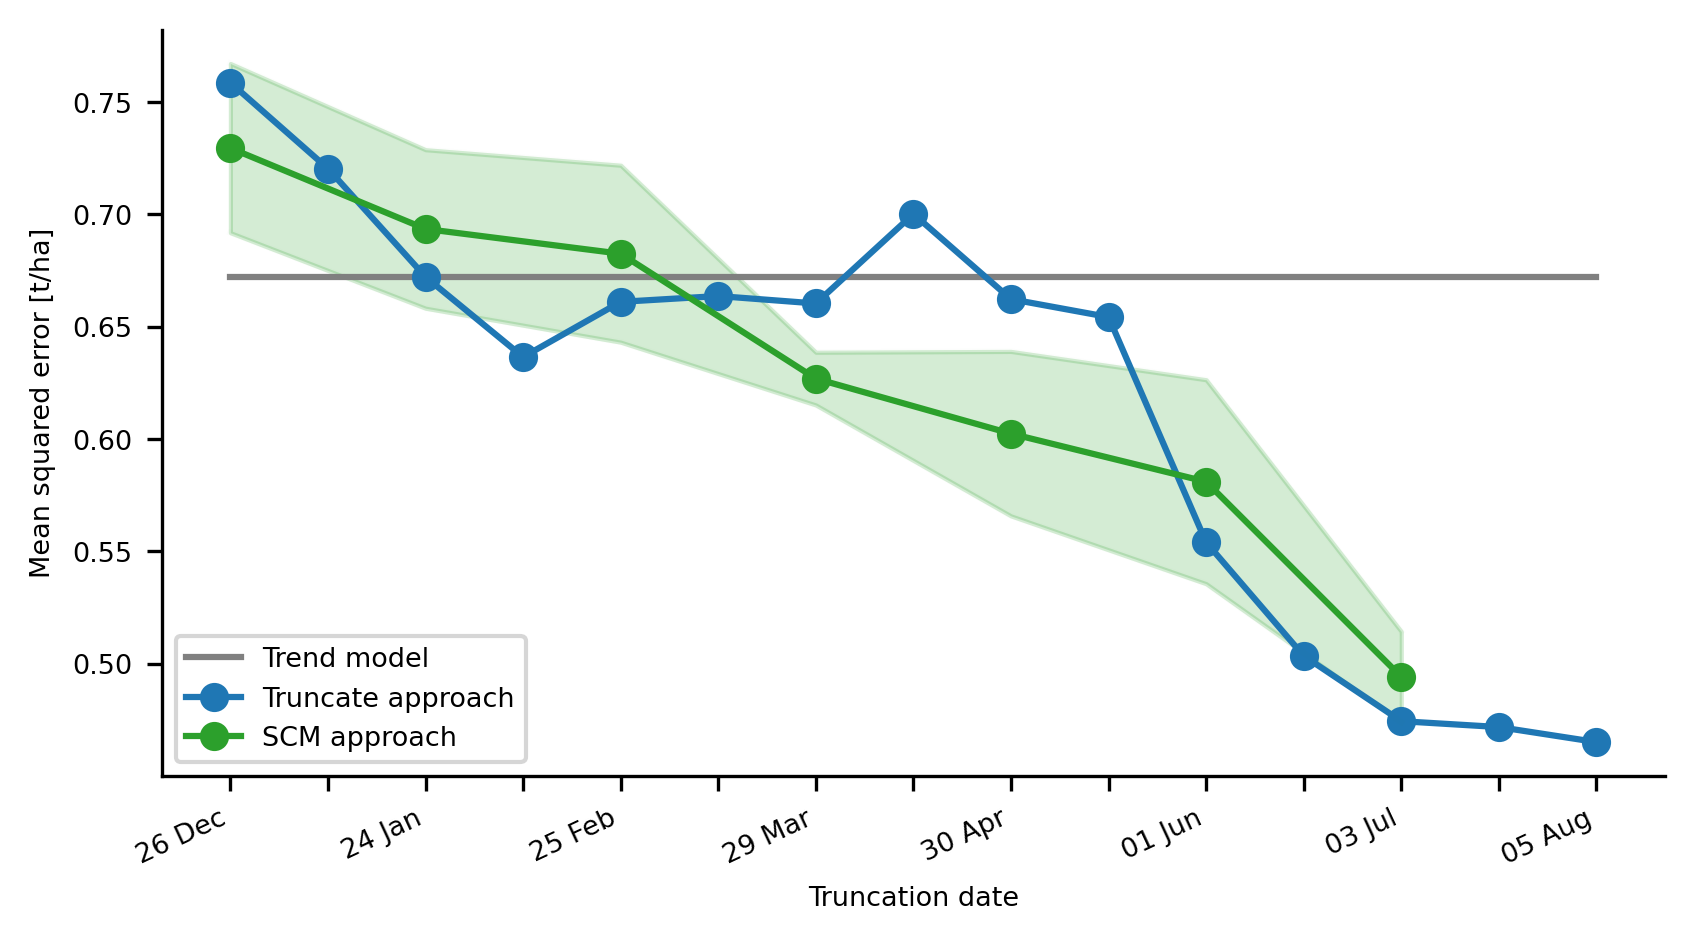

In [44]:
fontsize = 6.5
dpi = 300
mpl.rcParams['figure.dpi']= dpi

# Read truncated results
truncate_filenames = [f for f in os.listdir("data/results_US/truncation/") if ((f.startswith("test") and f.endswith(".csv")) and ("ba" not in f))]
truncated_dfs = []
for file in truncate_filenames:
    if not file.endswith(".csv"): continue
    df = (pd.read_csv(os.path.join("data/results_US/truncation/", file))
          .assign(truncation=int(file.replace(".csv", "").split("_")[-1]),
                  limit=time_step_to_date[int(file.replace(".csv", "").split("_")[-1])])
          .drop("Unnamed: 0", axis=1)
          .groupby(["truncation", "limit"]).apply(lambda x: np.mean((x["y_true"] - x["y_pred"])**2)).reset_index(name='MSE'))
    truncated_dfs.append(df)
truncated_df = pd.concat(truncated_dfs, ignore_index=True).sort_values(by="truncation").reset_index(drop=True)
truncated_df = truncated_df.loc[truncated_df["truncation"] >= 9].reset_index(drop=True)

# Read the forecasts of each SCM ensemble member
ensemble_filenames = os.listdir("data/results_US/scm 4 steps/ensembles/")
ensemble_dfs = []
for file in ensemble_filenames:
    if not file.endswith(".csv"): continue
    ensemble_member = int(file.split("_")[-1].strip(".csv"))
    df = pd.read_csv(os.path.join("data/results_US/scm 4 steps/ensembles/", file)).drop(columns=["Unnamed: 0"])    
    df = df.assign(truncation=scm_to_truncation[file.split("_")[8]], limit=time_step_to_date[scm_to_truncation[file.split("_")[8]]])
    ensemble_dfs.append(df)
ensemble_df = pd.concat(ensemble_dfs, ignore_index=True).sort_values(by=["truncation", "member"]).reset_index(drop=True)
ensemble_std = (ensemble_df.groupby(["truncation", "limit", "member"]).apply(lambda x: np.mean((x["y_true"] - x["y_pred"])**2)).reset_index(name='MSE')
 .groupby(["truncation", "limit"]).agg(mean_MSE=('MSE', 'mean'), std_MSE=('MSE', 'std')).reset_index()
 .assign(mean_MSE_upper=lambda x: x["mean_MSE"] + x["std_MSE"], mean_MSE_lower=lambda x: x["mean_MSE"] - x["std_MSE"]))

# Calculate MSE of trend model
eos_estimates = pd.read_csv("data/results_US/truncation/test_y_true_y_pred_timesteps_3_23.csv").drop(columns=["Unnamed: 0"])
features = pd.read_csv('C:/Users/Max Zachow/OneDrive - TUM/Dokumente/GitHub/seasonal-yield-forecast/data/preprocessed/US/cy_bench_16daybins_wheat_US_v8.csv')
mse_trend_model = (features[["adm_id", "harvest_year", "yield_-3", "yield_-2", "yield_-1"]]
                    .rename(columns={"harvest_year":"year"}).merge(eos_estimates[["adm_id", "year", "y_true"]], on=["adm_id", "year"], how="right")
                    .assign(threeyearavg = lambda x: x[["yield_-3", "yield_-2", "yield_-1"]].mean(axis=1))
                    .apply(lambda x: (x["y_true"] - x["threeyearavg"])**2, axis=1).mean())

plt.plot([9, 23], 2*[mse_trend_model], label="Trend model", linestyle="-", color="grey")
plt.plot(truncated_df["truncation"], truncated_df["MSE"], label="Truncate approach", marker="o")
plt.plot(ensemble_std["truncation"], ensemble_std["mean_MSE"], label="SCM approach", color='C2',marker="o")
plt.plot(ensemble_std["truncation"], ensemble_std["mean_MSE_upper"], label=None, color='C2', alpha=0.01)
plt.plot(ensemble_std["truncation"], ensemble_std["mean_MSE_lower"], label=None, color='C2', alpha=0.01)
plt.fill_between(ensemble_std["truncation"], ensemble_std["mean_MSE_lower"], ensemble_std["mean_MSE_upper"], color='C2', alpha=0.2)

plt.xlabel("Truncation date", fontsize=fontsize)
plt.ylabel("Mean squared error [t/ha]", fontsize=fontsize)
plt.xticks(ticks=range(9, 24), labels=truncated_df["limit"], rotation=25, fontsize=fontsize, ha="right")
plt.gca().set_xticklabels(truncated_df["limit"], rotation=25, fontsize=fontsize, ha="right")
for label in plt.gca().get_xticklabels()[1::2]:
    label.set_visible(False)
plt.yticks(fontsize=fontsize)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.legend(loc="lower left", fontsize=fontsize)
fig = plt.gcf()
fig.set_size_inches(468.3324*0.0138, (468.3324*0.0138/2))

#plt.savefig("figure6.png", dpi=dpi, bbox_inches='tight')
plt.show()

In [18]:
truncated_df

,truncation,limit,MSE
0,9,26 Dec,0.758659
1,10,08 Jan,0.720415
2,11,24 Jan,0.672205
3,12,09 Feb,0.636544
4,13,25 Feb,0.661098
5,14,13 Mar,0.663685
6,15,29 Mar,0.660374
7,16,14 Apr,0.700220
8,17,30 Apr,0.662290
9,18,16 May,0.654331


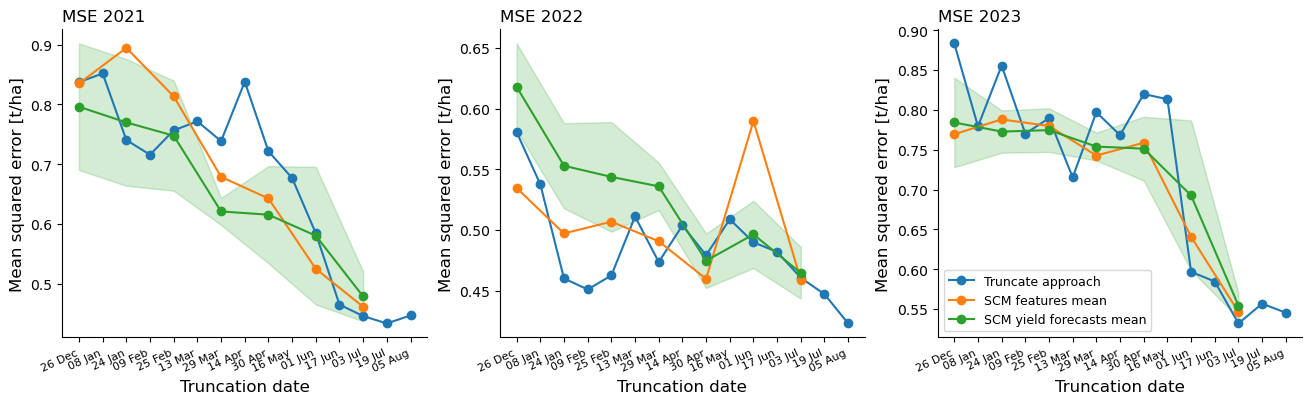

In [15]:
fig, axs = plt.subplots(1, 3, figsize=(16, 4))

# Read truncated results
truncate_filenames = [f for f in os.listdir("data/results_US/truncation/") if ((f.startswith("test") and f.endswith(".csv")) and ("ba" not in f))]
truncated_dfs = []
for file in truncate_filenames:
    if not file.endswith(".csv"): continue
    df = (pd.read_csv(os.path.join("data/results_US/truncation/", file))
          .assign(truncation=int(file.replace(".csv", "").split("_")[-1]),
                  limit=time_step_to_date[int(file.replace(".csv", "").split("_")[-1])])
          .drop("Unnamed: 0", axis=1)
          .groupby(["year", "truncation", "limit"]).apply(lambda x: np.mean((x["y_true"] - x["y_pred"])**2)).reset_index(name='MSE'))
    truncated_dfs.append(df)
truncated_df = pd.concat(truncated_dfs, ignore_index=True).sort_values(by="truncation").reset_index(drop=True)
truncated_df = truncated_df.loc[truncated_df["truncation"] >= 9].reset_index(drop=True)

# Read SCM ensemble mean results
scm_filenames = os.listdir("data/results_US/scm 4 steps/")
scm_dfs = []
for file in scm_filenames:
    if not file.startswith("test"): continue
    df = (pd.read_csv(os.path.join("data/results_US/scm 4 steps/", file)).drop(columns=["Unnamed: 0"])
          .assign(truncation=scm_to_truncation[file.split("_")[8]], limit=time_step_to_date[scm_to_truncation[file.split("_")[8]]])
          .groupby(["year", "truncation", "limit"]).apply(lambda x: np.mean((x["y_true"] - x["y_pred"])**2)).reset_index(name='MSE'))
    scm_dfs.append(df)
scm_df = pd.concat(scm_dfs, ignore_index=True).sort_values(by="truncation").reset_index(drop=True)

# Read the predictions of each SCM ensemble member
ensemble_filenames = os.listdir("data/results_US/scm 4 steps/ensembles/")
ensemble_dfs = []
for file in ensemble_filenames:
    if not file.endswith(".csv"): continue
    ensemble_member = int(file.split("_")[-1].strip(".csv"))
    df = pd.read_csv(os.path.join("data/results_US/scm 4 steps/ensembles/", file)).drop(columns=["Unnamed: 0"])    
    df = df.assign(truncation=scm_to_truncation[file.split("_")[8]], limit=time_step_to_date[scm_to_truncation[file.split("_")[8]]])
    ensemble_dfs.append(df)
ensemble_df = pd.concat(ensemble_dfs, ignore_index=True).sort_values(by=["truncation", "member"]).reset_index(drop=True)
end_of_season_predictions = pd.read_csv("data/results_US/truncation/test_y_true_y_pred_timesteps_3_23.csv").drop(columns=["Unnamed: 0"]).rename(columns={"y_pred": "y_pred_eos"})
ensemble_df = ensemble_df.merge(end_of_season_predictions[["adm_id", "year", "y_pred_eos"]], on=["adm_id", "year"], how="left")
ensemble_mean = ensemble_df.groupby(["year", "truncation", "limit"]).apply(lambda x: np.mean((x["y_true"] - x["y_pred"])**2)).reset_index(name='MSE')

ensemble_std = (ensemble_df.groupby(["year", "truncation", "limit", "member"]).apply(lambda x: np.mean((x["y_true"] - x["y_pred"])**2)).reset_index(name='MSE')
 .groupby(["year", "truncation", "limit"]).agg(mean_MSE=('MSE', 'mean'), std_MSE=('MSE', 'std')).reset_index()
 .assign(mean_MSE_upper=lambda x: x["mean_MSE"] + x["std_MSE"], mean_MSE_lower=lambda x: x["mean_MSE"] - x["std_MSE"]))

for ax, year in zip(axs, [2021, 2022, 2023]):
    ax.plot(truncated_df.loc[truncated_df["year"] == year, "truncation"], 
            truncated_df.loc[truncated_df["year"] == year, "MSE"], label="Truncate approach", marker="o")
    ax.plot(scm_df.loc[scm_df["year"] == year, "truncation"], 
            scm_df.loc[scm_df["year"] == year, "MSE"], label="SCM features mean", marker="o")
    ax.plot(ensemble_mean.loc[ensemble_mean["year"] == year, "truncation"], 
            ensemble_mean.loc[ensemble_mean["year"] == year, "MSE"], label="SCM yield forecasts mean", marker="o")
    ax.plot(ensemble_std.loc[ensemble_std["year"] == year, "truncation"], 
            ensemble_std.loc[ensemble_std["year"] == year, "mean_MSE_upper"], label=None, color='C2', alpha=0.01)
    ax.plot(ensemble_std.loc[ensemble_std["year"] == year, "truncation"], 
            ensemble_std.loc[ensemble_std["year"] == year, "mean_MSE_lower"], label=None, color='C2', alpha=0.01)
    ax.fill_between(ensemble_mean.loc[ensemble_mean["year"] == year, "truncation"], 
                    ensemble_std.loc[ensemble_std["year"] == year, "mean_MSE_lower"], 
                    ensemble_std.loc[ensemble_std["year"] == year, "mean_MSE_upper"], color='C2', alpha=0.2)
    ax.set_xlabel("Truncation date", fontsize=12)
    ax.set_ylabel("Mean squared error [t/ha]", fontsize=12)
    ax.set_xticks(ticks=range(9, 24), labels=truncated_df.loc[truncated_df["year"] == year, "limit"], rotation=25, fontsize=8, ha="right")
    ax.set_title(f"MSE {year}", loc="left", fontsize=12)
    #ax.plot([9, 23], 2*[np.mean((xy.loc[xy["year"] == year, "yield"] - xy.loc[xy["year"] == year, "threeyearavg"])**2)], label="Trend model approach", linestyle="-", color="grey")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if year == 2023:
        ax.legend(loc="lower left", fontsize=9)

plt.show()

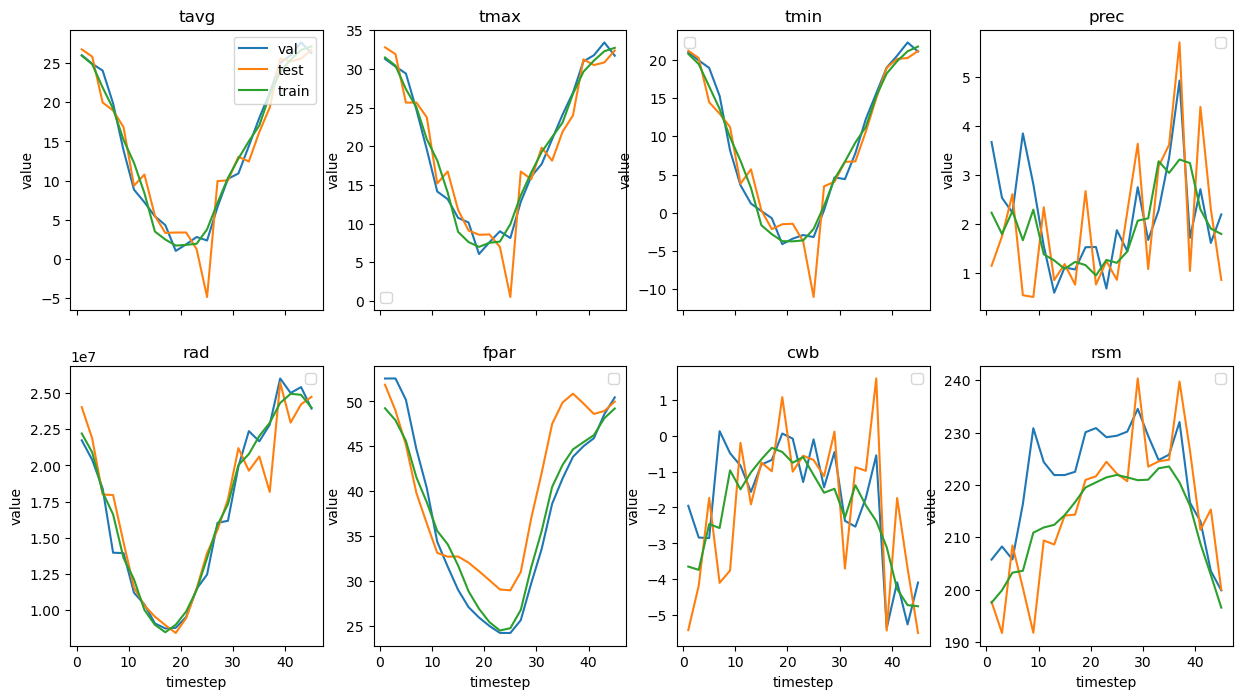

In [ ]:
df = features[["harvest_year"] 
         + [c for c in features.columns if c.startswith("tavg")] + [c for c in features.columns if c.startswith("rsm")] 
         + [c for c in features.columns if c.startswith("prec")] + [c for c in features.columns if c.startswith("tmax")]
         + [c for c in features.columns if c.startswith("tmin")] + [c for c in features.columns if c.startswith("cwb")]
         + [c for c in features.columns if c.startswith("fpar")] + [c for c in features.columns if c.startswith("rad")]]

df = df.assign(split=np.nan)
df.loc[df["harvest_year"].between(2004, 2017), "split"] = "train"
df.loc[df["harvest_year"].between(2018, 2020), "split"] = "val"
df.loc[df["harvest_year"].between(2021, 2021), "split"] = "test"
df = df.drop(columns=["harvest_year"])

#df = df.groupby("split").mean().reset_index()

fig, ax = plt.subplots(2, 4, figsize=(15, 8), sharex=True)
axs = ax.flatten()

for i, col in enumerate(["tavg", "tmax", "tmin", "prec", "rad", "fpar", "cwb", "rsm"]):
    data = df[["split"] + [c for c in df.columns if c.startswith(col)]]
    data = data.melt(id_vars="split", var_name="timestep", value_name="value")
    data["timestep"] = data["timestep"].apply(lambda x: int(x.split("_")[1]))
    val = data.loc[data["split"] == "val"].drop(columns="split")
    test = data.loc[data["split"] == "test"].drop(columns="split")
    train = data.loc[data["split"] == "train"].drop(columns="split")
    sns.lineplot(data=val, x="timestep", y="value", ax=axs[i], label="val")
    sns.lineplot(data=test, x="timestep", y="value", ax=axs[i], label="test")
    sns.lineplot(data=train, x="timestep", y="value", ax=axs[i], label="train")
    axs[i].set_title(col)
    axs[i].legend("")
    if i == 0:
        axs[i].legend(loc="upper right")
    
    
    

### 3. Observed vs. Forecasted Features

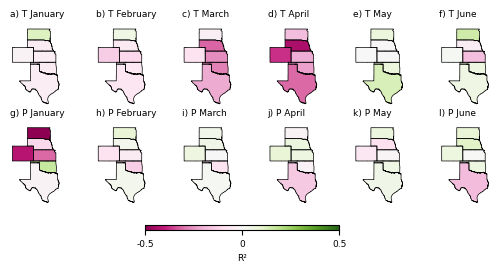

In [15]:
fontsize = 6.5
#dpi = 300
#mpl.rcParams['figure.dpi']= dpi
#fig, axs = plt.subplots(1, 3, figsize=(468.3324*0.0138, (468.3324*0.0138/4)))

month_to_name = {"jan": "January", "feb": "February", "mar": "March", "apr": "April", "may": "May", "june": "June"}
#feature_to_name = {"tavg": "Mean Temperature", "prec": "Precipitation", "tmax": "Maximum Temperature", "tmin": "Minimum Temperature"}
month_to_first_two_timesteps = {"jan":["19", "21", "23", "25"], "feb":["23", "25", "27", "29"], "mar":["27", "29", "31", "33"], "apr":["31", "33", "35", "37"], "may": ["35", "37", "39", "41"], "june": ["39", "41", "43", "45"]}#
position_to_index = {"00": "a)", "01": "b)", "02": "c)", "03": "d)", "04": "e)", "05": "f)", "10": "g)", "11": "h)", "12": "i)", "13": "j)", "14": "k)", "15":"l)"}
feature_name_to_abbreviation = {"Temperature": "T", "Precipitation": "P"}
fig, axs = plt.subplots(2, 6, figsize=(468.3324*0.0138, (468.3324*0.0138/2.75)))

for i, init_month in enumerate(["jan", "feb", "mar", "apr", "may", "june"]):
    obs_features = (features
                    .loc[features["harvest_year"].between(2021, 2023), ["adm_id", "harvest_year"] + [c for c in features.columns if c.startswith("tavg") or c.startswith("prec") or c.startswith("tmax") or c.startswith("tmin")]]
                    .set_index(["adm_id", "harvest_year"]))

    obs_features_mean = (features
                            .loc[(features["harvest_year"].between(2004, 2017)) & (features["adm_id"].isin(xy["adm_id"].unique())), ["adm_id"] + [c for c in features.columns if c.startswith("tavg") or c.startswith("prec") or c.startswith("tmax") or c.startswith("tmin")]]
                            .groupby("adm_id").mean())

    scm_features = pd.read_csv('C:/Users/Max Zachow/OneDrive - TUM/Dokumente/GitHub/seasonal-yield-forecast/data/preprocessed/US/ecmwf_wheat_US_ba_{}_16daybins.csv'.format(init_month))
    #scm_features_no_ba = pd.read_csv('C:/Users/Max Zachow/OneDrive - TUM/Dokumente/GitHub/seasonal-yield-forecast/data/preprocessed/US/ecmwf_wheat_US_no_ba_{}_16daybins.csv'.format(init_month))
    #prec_columns = [col for col in scm_features.columns if col.startswith('prec')]
    #scm_features[prec_columns] = scm_features_no_ba[prec_columns]

    scm_features.rename(columns={"year":"harvest_year"}, inplace=True)
    scm_features.drop(columns=["number", "init_date", "init_time_step"], inplace=True)
    scm_features.set_index(["adm_id", "harvest_year"], inplace=True)
    scm_features = scm_features[scm_features.index.isin(obs_features.index)]
    scm_features = scm_features.groupby(level=[0,1]).mean()
    scm_features = scm_features.loc[:, [c for c in scm_features.columns if c.split("_")[1] in month_to_first_two_timesteps[init_month]]]
    obs_features = obs_features[scm_features.columns]
    obs_features_mean = obs_features_mean[scm_features.columns]
    
    squared_errors_scm = (obs_features - scm_features)**2
    squared_errors_scm_temp = squared_errors_scm.loc[:, squared_errors_scm.columns.str.split('_').str[0].isin(["tavg", "tmax", "tmin"])].sum(axis=1)
    squared_errors_scm_prec = squared_errors_scm.loc[:, squared_errors_scm.columns.str.split('_').str[0] == "prec"].sum(axis=1)
    squared_errors_scm = pd.concat([squared_errors_scm_temp, squared_errors_scm_prec], axis=1)
    squared_errors_scm.columns = ["Temperature", "Precipitation"]
    sum_of_squared_errors_model = squared_errors_scm.reset_index().groupby("adm_id")[["Temperature", "Precipitation"]].sum()

    squared_errors_reference = (obs_features - obs_features_mean)**2
    squared_errors_reference_temp = squared_errors_reference.loc[:, squared_errors_reference.columns.str.split('_').str[0].isin(["tavg", "tmax", "tmin"])].sum(axis=1)
    squared_errors_reference_prec = squared_errors_reference.loc[:, squared_errors_reference.columns.str.split('_').str[0] == "prec"].sum(axis=1)
    squared_errors_reference = pd.concat([squared_errors_reference_temp, squared_errors_reference_prec], axis=1)
    squared_errors_reference.columns = ["Temperature", "Precipitation"]
    sum_of_squared_errors_reference = squared_errors_reference.reset_index().groupby("adm_id")[["Temperature", "Precipitation"]].sum()

    r_squared = 1 - sum_of_squared_errors_model / sum_of_squared_errors_reference

    r_squared = r_squared.reset_index().merge(us_counties[["adm_id", "STATEFP", "geometry"]], on="adm_id", how="left")
    r_squared = gpd.GeoDataFrame(r_squared, geometry="geometry")
    #fig.text(0.1, 0.75 - i * 0.25, "{}".format(month_to_name[init_month]), va='center', ha='center', rotation='vertical', fontsize=11)
    
    for j, feature in enumerate(["Temperature", "Precipitation"]):
        r_squared_state = r_squared[["STATEFP", feature, "geometry"]].dissolve(by="STATEFP", aggfunc="mean").reset_index()
        r_squared_state = r_squared_state[["STATEFP", feature]].merge(us_states, on="STATEFP", how="right")
        r_squared_state = gpd.GeoDataFrame(r_squared_state, geometry="geometry")
        r_squared_state.plot(column=feature, cmap="PiYG", legend=False, vmin=-1, vmax=1, ax=axs[j][i])
        us_states.plot(facecolor="none", edgecolor='black', linewidth=0.5, ax=axs[j][i])
        axs[j][i].spines[['top', 'right', 'bottom', 'left']].set_visible(False)
        axs[j][i].set_xticks([])
        axs[j][i].set_yticks([])
        #if i == 0: 
            #axs[j][i].set_ylabel("Latitude [°]", fontsize=11)
        
        axs[j][i].set_title(position_to_index["{}{}".format(j,i)] + " " + feature_name_to_abbreviation[feature] + " " + month_to_name[init_month], loc="left", fontsize=fontsize)
        #if i == 2: axs[j][i].set_xlabel("Longitude [°]", fontsize=11)

# Create a colorbar axis below the entire figure
cbar_ax = fig.add_axes([0.35, 0.01, 0.3, 0.02])
sm = plt.cm.ScalarMappable(cmap="PiYG", norm=plt.Normalize(vmin=-0.5, vmax=0.5))
cbar = fig.colorbar(sm, cax=cbar_ax, orientation="horizontal")
cbar.set_ticks([-0.5, 0, 0.5])
cbar.ax.set_xticklabels(['-0.5', '0', '0.5'], fontsize=fontsize)
cbar.set_label('R²', fontsize=fontsize)

plt.savefig("figure8.png", dpi=300, bbox_inches='tight')
plt.show()

In [48]:
np.quantile(r_squared[["Temperature", "Precipitation"]].values.flatten(), [0.05, 0.95])

array([-0.81773362,  0.51054021])